### 1.- Declare network & load sample model

In [146]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
import time

import torch 
import torch.nn as nn

device = torch.device("cpu")

class AE(nn.Module):
    def __init__(self, n_comps, n_coeffs):
        super(AE, self).__init__()
        self.n_coeffs = n_coeffs
        self.n_comps = n_comps
        self.D = nn.Linear(1, self.n_comps*404*404, bias=False)
        self.conv1 = nn.Conv2d(self.n_comps, 2*self.n_comps, kernel_size=5, bias=False)
        self.coeffs = nn.Linear(1, 2*self.n_comps*self.n_coeffs, bias=False)
        
    def forward(self, x):
        base = self.D(x)
        conv1 =  torch.tanh(self.conv1(base.reshape(1, self.n_comps, 404, 404)))   
        coeffs = self.coeffs(x).view(2*self.n_comps, self.n_coeffs)
        #return torch.einsum('ik,kj->ji', conv1.view(400*400, 2*self.n_comps), coeffs)
        return torch.einsum('ki,kj->ji', conv1.view(2*self.n_comps,400*400), coeffs)
    
net = torch.load("00_00_net.pt", map_location='cpu')
net.eval()

AE(
  (D): Linear(in_features=1, out_features=1958592, bias=False)
  (conv1): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (coeffs): Linear(in_features=1, out_features=11928, bias=False)
)

### Extract values of the base and convolution kernel

In [176]:
base = net.D.weight.detach().numpy().reshape(1,12,404,404)
ker = net.conv1.weight.detach().numpy()

base.shape, ker.shape

((1, 12, 404, 404), (24, 12, 5, 5))

### Run Pytorch convolution and display first component

Pytorch conv op: 0.02230691909790039 seconds


(-0.038715113, 0.008109524)

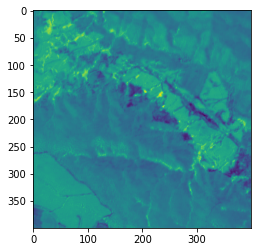

In [154]:
start = time.time()
conv1 = net.conv1(net.D(input).reshape(1, 12, 404, 404)).detach().numpy()
print(f"Pytorch conv op: {time.time()-start} seconds")

plt.imshow(conv1[0,0,:,:])

# Ref values
conv1[0,0,200,200], conv1[0,12,200,200]

### Using numpy einsum to implement convolution

Numpy einsum conv op: 1.496849536895752 seconds


(-0.038715106, 0.008109526)

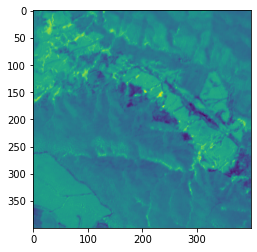

In [165]:
from numpy.lib.stride_tricks import as_strided

def conv2d(a, b):

  a = as_strided(a, (a.shape[0], a.shape[1], a.shape[2] - b.shape[2] + 1, a.shape[3] - b.shape[3] + 1, 
                     b.shape[2], b.shape[3]), a.strides[:] + a.strides[2:])
  
  return np.einsum('akbcij,dkij', a, b)

start = time.time()
conv1_eins = conv2d(base, ker)
print(f"Numpy einsum conv op: {time.time()-start} seconds")

plt.imshow(conv1_eins[0,:,:,0])

# Ref values
conv1_eins[0,200,200,0], conv1_eins[0,200,200,12]

### Using numpy dot (+ move axis) to implement convolution

Numpy dot conv op: 0.10679030418395996 seconds


(-0.038715113, 0.008109524)

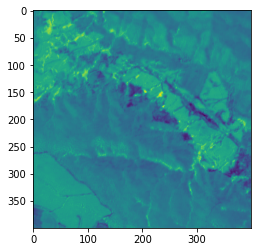

In [166]:
def conv2d(a, b):
    a = as_strided(a,(len(a),a.shape[1]-len(b)+1,a.shape[2]-b.shape[1]+1,len(b),
                      b.shape[1],a.shape[3]),a.strides[:3]+a.strides[1:])
    
    return np.tensordot(a, b, axes=3)


start = time.time()
base = np.moveaxis(base,1,-1)
ker = np.moveaxis(ker,1,-1)
ker = np.moveaxis(ker,0,-1)
conv1_dot = conv2d(base, ker)
print(f"Numpy dot conv op: {time.time()-start} seconds")

# Regenerate tensors
base = net.D.weight.detach().numpy().reshape(1,12,404,404)
ker = net.conv1.weight.detach().numpy()

plt.imshow(conv1_dot[0,:,:,0])

# Ref values
conv1_dot[0,200,200,0], conv1_dot[0,200,200,12]

### Running entire network

Pytorch conv op: 0.09134364128112793 seconds


(-0.049737807, -0.05745024)

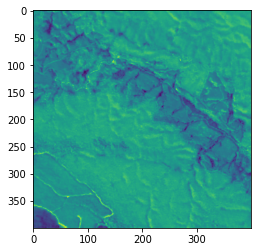

In [172]:
start = time.time()
conv1 = torch.tanh(net.conv1(net.D(input).reshape(1, 12, 404, 404)))#.detach().numpy()
coeffs = net.coeffs(input).view(2*net.n_comps, net.n_coeffs)
res = torch.einsum('ki,kj->ji', conv1.view(2*net.n_comps,400*400), coeffs).detach().numpy().reshape(-1,400,400)
#plt.imshow(conv1.detach().numpy()[0,4,:,:])


print(f"Pytorch conv op: {time.time()-start} seconds")
plt.imshow(res[0,:,:])

# Ref values
res[0,200,200], res[12,200,200]

(576,)
Numpy dot conv op: 0.21056127548217773 seconds
(24, 400, 400)


(-0.049737807, -0.057450242)

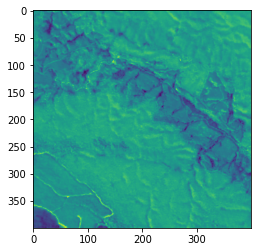

In [183]:
def conv2d(a, b):
    a = as_strided(a,(len(a),a.shape[1]-len(b)+1,a.shape[2]-b.shape[1]+1,len(b),
                      b.shape[1],a.shape[3]),a.strides[:3]+a.strides[1:])
    
    return np.tensordot(a, b, axes=3)

coeffs = net.coeffs.weight.detach().numpy()
coeffs = coeffs.reshape(24,-1)[:,:24].flatten()
print(coeffs.shape)

start = time.time()
base = np.moveaxis(base,1,-1)
ker = np.moveaxis(ker,1,-1)
ker = np.moveaxis(ker,0,-1)
conv1_dot = np.tanh(conv2d(base, ker))
res = np.einsum('ik,kj->ji', conv1_dot.reshape(-1,24), coeffs.reshape(24,-1))
print(f"Numpy dot conv op: {time.time()-start} seconds")

res = res.reshape(-1,400,400)

# Regenerate tensors
base = net.D.weight.detach().numpy().reshape(1,12,404,404)
ker = net.conv1.weight.detach().numpy()

print(res.shape)
plt.imshow(res[0,:,:])

# Ref values
res[0,200,200], res[12,200,200]